In [1]:
#Tag:Library linking
#basic python
import pandas as pd  
pd.set_option('display.max_rows', 20)    #show setting
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")  #dont show the fxxking warning
%matplotlib inline

#spider
import requests

#data processing && sklearn
from math import sqrt #for Root-MSE(RMSE)
from sklearn.preprocessing import MinMaxScaler       #normalization
from sklearn.metrics import mean_squared_error       #MSE loss evaluation1
from sklearn.metrics import mean_absolute_error      #MAE loss evaluation2
from sklearn.metrics import explained_variance_score #loss evaluation3
from sklearn.metrics import r2_score                 #loss evaluation4
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#keras' model && LSTM algorithm
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout,BatchNormalization

In [2]:
#Tag:Data source 
url = []
url.append("https://api.finmindtrade.com/api/v4/login") #login
url.append("https://api.finmindtrade.com/api/v4/data")  #data fetch
dataset = []
dataset.append("TaiwanStockPrice")
dataset.append("TaiwanStockMarginPurchaseShortSale")
dataset.append("TaiwanStockPER")
dataset.append("TaiwanStockTotalMarginPurchaseShortSale")

In [3]:
#Tag:Input control(for dev.)
TRAIN = '開盤價'
TARGET = '收盤價'

corr_rate = 0.1     #correlation threshold
step = 5            #rolling times
shift = 10          #rolling shift

show_history_dataframe = False
show_LSTM_config = False   #(=setting summary)
show_loss_plot = True

multi = True         #False=uniVariate True=multiVariate
unit = 100           #units-------num of neural cells
drop_rate = 0.2      #drop--------drop some node by this rate
times = 150          #epoch-------whole data set training times
group_size = 64      #batch_size--selection size per expiriment
train_record = 0     #verbose-----0=dont show, 1=show record and progress, 2=record only 
shuff = True         #shuffle-----make random
loss_select = 1      #choose loss function
loss_func = ['mean_absolute_error','mean_squared_error']

In [4]:
#Tag:Input control(for User)
#note:change it if u have ur own account for Finmind 
user_id = "GodFather"    #by default
password = "oldfashioned"  #by default

symbol = "2330"          #stock id
start_date = "2016-06-04"
end_date = "2021-06-03"

show_history_plot = False
save_history_plot = False
show_prediction = True
save_prediction = False

In [5]:
#Tag:function area
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def confusion_matrix_list(real,predict):
    real_tendency=[]
    predicted_tendency=[]
       
    for i in range(1,len(real)):
        if(real[i]-real[i-1]>0):
            real_tendency.append(1)
        if(real[i]-real[i-1]==0):
            real_tendency.append(2)
        if(real[i]-real[i-1]<0):
            real_tendency.append(0)
    for i in range(1,len(predict)):
        if(predict[i]-predict[i-1]>0):
            predicted_tendency.append(1)
        if(predict[i]-predict[i-1]==0):
            pedicted_tendency.append(2)
        if(predict[i]-predict[i-1]<0):
            predicted_tendency.append(0)
    
    return real_tendency,predicted_tendency 

In [6]:
#Tag:login && data fetch && manage(feat. FINmind)
#------login && get *Token
account = {
    "user_id": user_id,
    "password": password,
}
token = requests.post(url[0], data=account).json()['token']

#------Add basic stock info. && parameter
parameter = {
    "dataset": dataset[0],
    "data_id": symbol,
    "start_date": start_date,
    "end_date": end_date,
    "token":token
}
#Fetch
data = pd.DataFrame(requests.get(url[1], params=parameter).json()["data"])

#------Add margin && shortsale
parameter = {
    "dataset": dataset[1],
    "data_id": symbol,
    "start_date": start_date,
    "end_date": end_date,
    "token":token,
}
#Fetch
data2 = pd.DataFrame(requests.get(url[1], params=parameter).json()["data"])
#Modify
data2=data2[["MarginPurchaseTodayBalance","MarginPurchaseYesterdayBalance","ShortSaleTodayBalance","ShortSaleYesterdayBalance"]]
data2["MarginPurchaseVariation"]=data2["MarginPurchaseTodayBalance"]-data2["MarginPurchaseYesterdayBalance"]
data2["ShortSaleVariation"]=data2["ShortSaleTodayBalance"]-data2["ShortSaleYesterdayBalance"]
data2=data2.drop(len(data2)-1,axis=0)#trim the length of data 

#------Add PER PBR
parameter = {
    "dataset": dataset[2],
    "data_id": symbol,
    "start_date": start_date,
    "end_date": end_date,
    "token":token,
}
#Fetch
data3 = pd.DataFrame(requests.get(url[1], params=parameter).json()['data'])
#Modify
data3=data3.drop(["date","stock_id"],axis=1)
data3=data3.drop(len(data3)-1,axis=0)

#------Add Total margin && shortsale
parameter = {
    "dataset": dataset[3],
    "start_date": start_date,
    "end_date": end_date,
    "token":token,
}
#Fetch
data4 = pd.DataFrame(requests.get(url[1], params=parameter).json()['data'])[["TodayBalance","name"]]
#Modify
data4=data4[~data4['name'].isin(["MarginPurchase"])]
MarginPurchaseMoney=data4[data4["name"]=="MarginPurchaseMoney"].drop(columns="name")
MarginPurchaseMoney.rename(columns={"TodayBalance":"MarginPurchaseMoney"})
MarginPurchaseMoney=MarginPurchaseMoney["TodayBalance"]/10000000
MarginPurchaseMoney=MarginPurchaseMoney.to_frame().rename(columns={"TodayBalance":"MarginPurchaseMoney"})
ShortSale=data4[data4["name"]=="ShortSale"].drop(columns="name")
ShortSale=ShortSale.rename(columns={"TodayBalance":"Shortsale"})
mod=list(range(len(data)))
MarginPurchaseMoney=MarginPurchaseMoney.set_axis(mod)
ShortSale=ShortSale.set_axis(mod)
data4=MarginPurchaseMoney.join(ShortSale)
data4=data4.drop(len(data4)-1,axis=0)#trim the length of data 

#------Add TAIEX
#data5 = pd.read_csv('TAIEX.csv')
#data5=data5.iloc[::-1]
#mod=list(range(len(data)))
#data5=data5.set_axis(mod).drop(["Date","Return",'Percent'],axis=1)
#data5.columns = ['大盤指數','漲跌點數']

#------Merge all data && translation
data=data.join(data2)
data=data.join(data3)
data=data.join(data4)
#data=data.join(data5)
data.columns=["日期","股票編號","當日成交量","當日成交金額","開盤價","最高價","最低價","收盤價","買賣價差","周轉率","當日融資","昨日融資","當日融卷","昨日融卷","融資變化","融券變化","殖利率","本益比","股價淨值比","大盤融資餘額(百萬)","大盤融卷量"]

data=data.drop("股票編號",axis=1)
data.set_index(["日期"], inplace=True)
data.insert(2,column="平均成交價",value=(data["當日成交金額"]/data["當日成交量"]).tolist())

if show_history_dataframe:
    display(data)


In [7]:
#Tag:data preprocessing
#------choose correlative data
for column in data:
    temp = []
    for i in range(step):
        temp.append(data[column].rolling((i+1)*shift).corr(data[TARGET]).mean())
    if sum(temp)/len(temp) < corr_rate:
        data = data.drop(column,axis=1)

In [8]:
#Tag:Univariate
#------slice data to test && train
if not multi:
    test = data[data.index>'2020-06-04']
    train = data[data.index<='2021-06-04']
    train_set_x = train[TRAIN]
    train_set_y = train[TARGET]

#------data normalization
    sc = MinMaxScaler(feature_range = (0, 1))      #re-scale data to the same range(aka. normalization) 
    train_set_x= train_set_x.values.reshape(-1,1)  #reshape: -1 = auto-calculate for fitting matrix size
    training_set_scaled_x = sc.fit_transform(train_set_x)
    train_set_y= train_set_y.values.reshape(-1,1)
    training_set_scaled_y = sc.fit_transform(train_set_y)

#------train data re-arrange
    X_train = [] 
    y_train = []
    for i in range(10,len(train_set_x)):
        X_train.append(training_set_scaled_x[i-10:i, 0]) 
        y_train.append(training_set_scaled_y[i, 0]) 
    X_train, y_train = np.array(X_train), np.array(y_train) 
    X_train = np.reshape(X_train,(X_train.shape[0], X_train.shape[1], 1))

#Tag:LSTM && keras model implementation
#------model config
    keras.backend.clear_session()
    model = Sequential()                                               #set-up a sequential
    model.add(LSTM(unit,return_sequences=True,input_shape=(X_train.shape[1], 1))) #add layer(lstm)
    model.add(Dropout(drop_rate))                                                              #add layer(dropout)
    model.add(LSTM(unit,activation='relu'))                                       #add layer(lstm)
    model.add(Dense(units = 1))                                                          #add layer(dense)
    model.compile(optimizer = 'adam', loss = loss_func[loss_select])     #optimized learning && loss evaluation
    
#------trainning
    history = model.fit(X_train, y_train, epochs = times, batch_size = group_size,verbose = train_record, shuffle = shuff)

#------make prediction
    dataset_total = pd.concat((train[TRAIN], test[TARGET]), axis = 0)
    inputs = dataset_total[len(dataset_total) - len(test) - 10:].values
    inputs = inputs.reshape(-1,1)
    inputs = sc.transform(inputs)
    X_test = []
    for i in range(10, len(inputs)):
        X_test.append(inputs[i-10:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    predicted_stock_price = model.predict(X_test)                    #make prediction
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)  #return to original scale

In [9]:
#Tag:multivariate
if multi:
    sc = MinMaxScaler(feature_range = (0, 1))      #re-scale data to the same range(aka. normalization) 
    scaled = sc.fit_transform(data.values)

# specify the number of lag hours
    n_days = 10 #可再調整
    n_features = data.shape[1]
    reframed = series_to_supervised(scaled, n_days, 1)

    vals = reframed.values
    n_train_day = 1000
    train = vals[:n_train_day, :]
    test = vals[n_train_day:, :]

#------split into input and outputs
    n_obs = n_days * n_features
    train_X, train_y = train[:, :n_obs], train[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -n_features]

#------reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_days, n_features))

    model2 = Sequential()
    model2.add(LSTM(unit, input_shape=(train_X.shape[1], train_X.shape[2])))
    model2.add(Dropout(drop_rate))
    model2.add(Dense(1))
    model2.compile(loss = loss_func[loss_select], optimizer='adam')
    model2.summary()

    history = model2.fit(train_X, train_y, epochs=times, batch_size=group_size, validation_data=(test_X, test_y), verbose=train_record, shuffle=shuff)

#------make prediction
    yhat = model2.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], n_days*n_features))

#------invert scaling for forecast
    inv_yhat = np.concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
    inv_yhat = sc.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]

#------invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
    inv_y = sc.inverse_transform(inv_y)
    inv_y = inv_y[:,0]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               45600     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 45,701
Trainable params: 45,701
Non-trainable params: 0
_________________________________________________________________


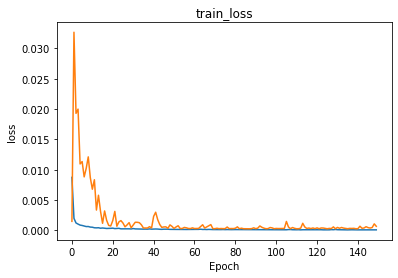

In [10]:
#Tag:show plots
if show_history_plot:
    fig=plt.figure(figsize=(20,8))
    plt.xticks(rotation = 90)  
    ax1 = fig.add_subplot(111)
    ax1.plot(data.收盤價,color='red',label='收盤價')
    ax1.plot(data.開盤價,color='green',label='開盤價')
    plt.legend()
    ax2 = ax1.twinx() #twinx = share x-axis
    plt.bar(data.日期,data.當日成交量.astype('int')//1000)
    ax3 = ax1.twinx()
    if save_history_plot:
        plt.savefig(symbol+'_year.png')
if show_LSTM_config:
    display(model.summary())
if show_loss_plot:
    plt.title('train_loss')
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.plot( history.history["loss"])
    if multi:
        plt.plot(history.history['val_loss'], label='test')
    plt.show()
if show_prediction:
    if not multi:
        plt.plot(test[TARGET].values, color = 'black', label = 'Real stock data')
        plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Stock data')
        plt.title('Stock Price Prediction')
        plt.xlabel('Time')
        plt.ylabel('TARGET')
        plt.legend()
        plt.show()
        print("TARGET = "+TARGET)
    else:
        plt.plot(inv_y, color = 'black', label = 'Real Stock Price ')
        plt.plot(inv_yhat, color = 'green', label = 'Predicted Stock Price')
        plt.title('Stock Price Prediction')
        plt.xlabel('Time')
        plt.legend()
        plt.show()
    
    if save_prediction:
        plt.savefig('lstm_2330.png')

In [11]:
#Tag:Evaluation report
print("Score:")
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('RMSE: %.3f' % rmse)

evs = explained_variance_score(inv_y, inv_yhat)
print('EVS : %.3f' % evs)

r2=r2_score(inv_y,inv_yhat)
print('r2: %.3f' % r2)
print()
real,predict=confusion_matrix_list(inv_y,inv_yhat)
matrix=confusion_matrix(real,predict,labels=[1,0,2])
print("confusion matrix:\n",matrix,'\n')

report=classification_report(real,predict,labels=[1,0,2])
print("Report:\n",report)

Score:
RMSE: 13.279
EVS : 0.983
r2: 0.971

confusion matrix:
 [[69 39  0]
 [44 58  0]
 [ 0  0  0]] 

Report:
               precision    recall  f1-score   support

           1       0.61      0.64      0.62       108
           0       0.60      0.57      0.58       102
           2       0.00      0.00      0.00         0

   micro avg       0.60      0.60      0.60       210
   macro avg       0.40      0.40      0.40       210
weighted avg       0.60      0.60      0.60       210

